# Install important dependencies

In [3]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 68 Mar 10 04:27 kaggle.json


In [4]:
!pip install -q kaggle

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d mahdinavaei/brain-tumor-mri-images-huge

 99% 1.58G/1.59G [00:11<00:00, 123MB/s]
100% 1.59G/1.59G [00:11<00:00, 149MB/s]


In [10]:
!unzip brain-tumor-mri-images-huge.zip

Streaming output truncated to the last 5000 lines.
  inflating: brain tumor MRI images/train/Pituitary tumor/Pituitary tumor_original_1634.png_f115247b-475e-49a1-ab79-89acfce7bcd6.png  
  inflating: brain tumor MRI images/train/Pituitary tumor/Pituitary tumor_original_1636.png_403647cc-40a5-4845-840b-f9c087060258.png  
  inflating: brain tumor MRI images/train/Pituitary tumor/Pituitary tumor_original_1636.png_9cdffef1-d539-4af9-817c-658109fb468a.png  
  inflating: brain tumor MRI images/train/Pituitary tumor/Pituitary tumor_original_1636.png_d5d60169-a475-4c90-9a19-0400044c96c3.png  
  inflating: brain tumor MRI images/train/Pituitary tumor/Pituitary tumor_original_1636.png_fdabee5f-faef-4606-9cfa-aba2d7533a63.png  
  inflating: brain tumor MRI images/train/Pituitary tumor/Pituitary tumor_original_1637.png_4e61bbb5-07fa-439b-988a-b158f453ce58.png  
  inflating: brain tumor MRI images/train/Pituitary tumor/Pituitary tumor_original_1637.png_6af00ea8-19a2-4eff-bd43-3e22e466212a.png  
  in

# Import dependencies

In [1]:
import os
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

In [2]:
gpus=tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

# Data Preprocessing

In [3]:
# saving the location of the base directory

base_dir = "brain-tumor-classification-mri"

In [4]:
from keras.preprocessing.image import ImageDataGenerator

In [5]:
data=tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    brightness_range=(.8,1),
    zoom_range=.02,
    rotation_range=.05,
    rescale=1./255,
)

In [6]:
train_data=data.flow_from_directory(
    directory=os.path.join(base_dir,'train'),
    target_size=(224,224),
    batch_size=32,
    shuffle=True,
    subset='training'
)
test_data=data.flow_from_directory(
    directory=os.path.join(base_dir,'val'),
    target_size=(224,224),
    batch_size=32,
)

Found 18392 images belonging to 3 classes.
Found 828 images belonging to 3 classes.


In [7]:
images,labels=train_data.next()
print(images.shape,labels.shape)

(32, 224, 224, 3) (32, 3)


In [8]:
labels[:5], images.shape

(array([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.]], dtype=float32),
 (32, 224, 224, 3))

In [9]:
class_labels=['Glioma','Meningioma','Pituitary']

In [10]:
plt.style.use('fivethirtyeight')
def plot_images(images):
    fig=plt.figure()
    fig.set_figwidth(20)
    fig.set_figheight(10)
    for idx in range(8):
        plt.subplot(2,4,idx+1)
        plt.imshow(images[idx])
        plt.title(class_labels[np.argmax(labels[idx],axis=0)])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

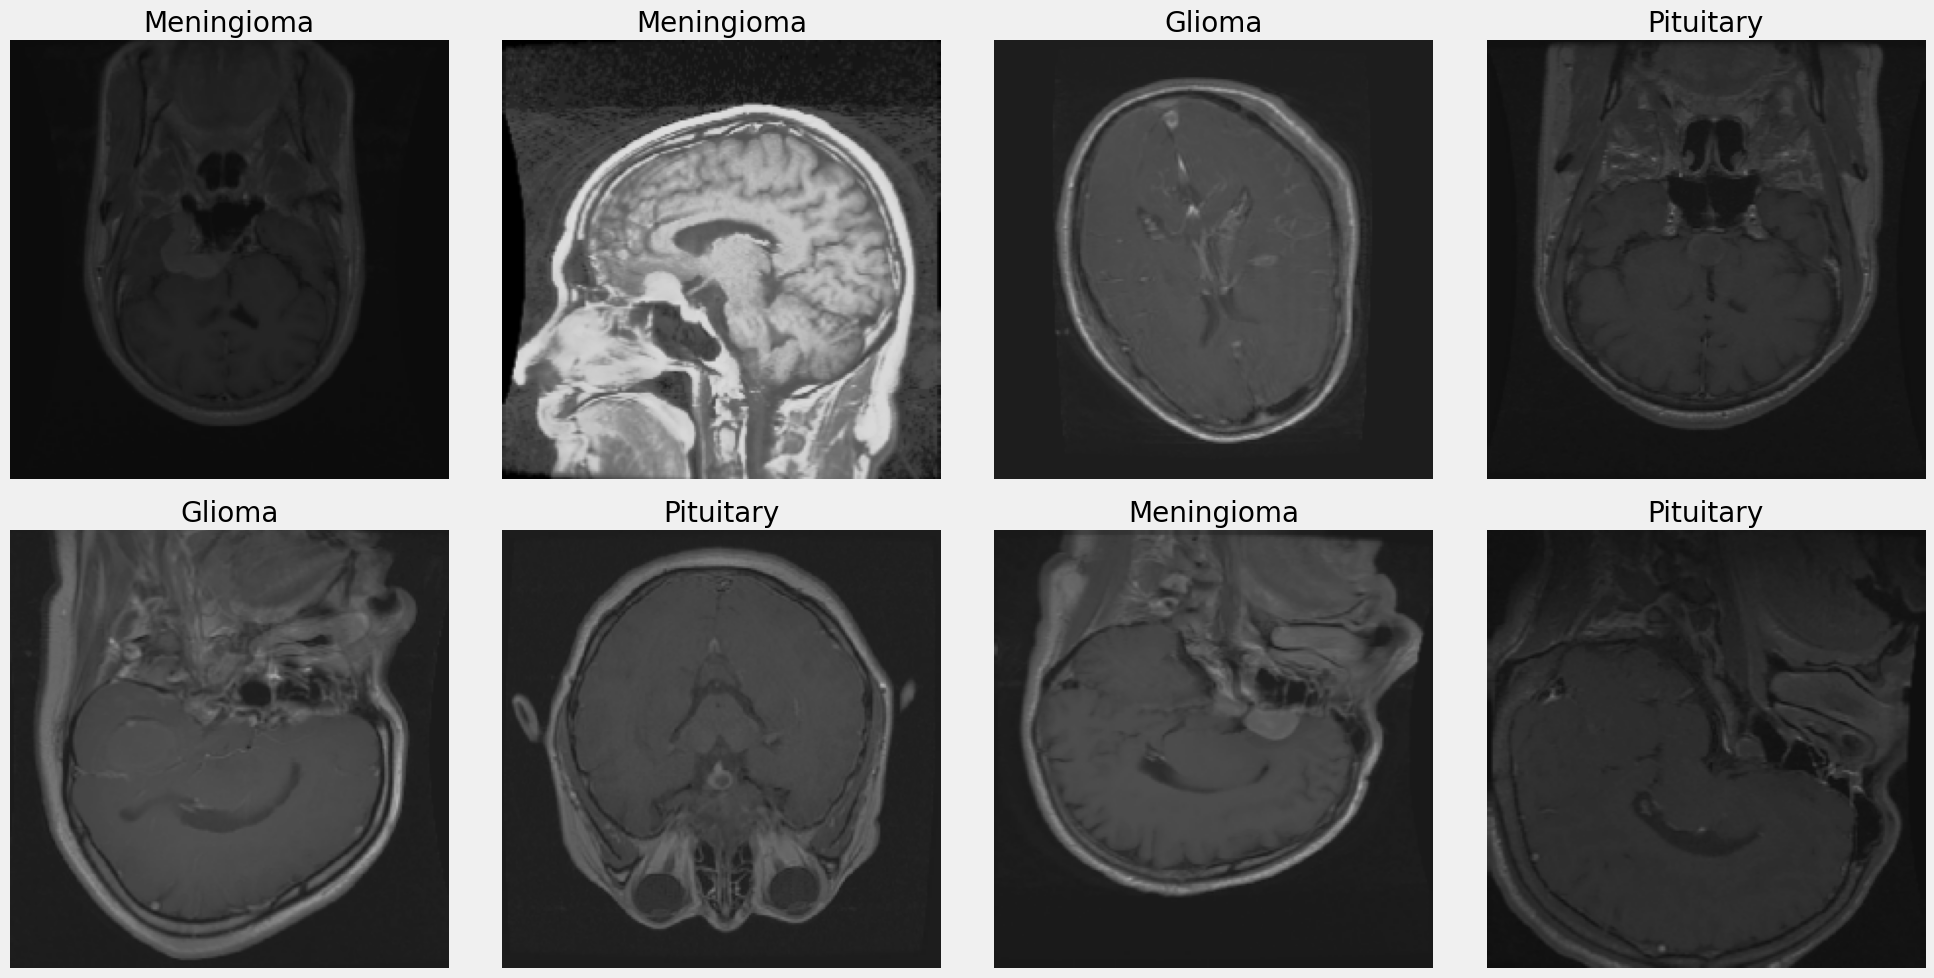

In [11]:
images,labels=train_data.next()
plot_images(images)

# Build a deep learning model

In [12]:
pre_model = tf.keras.applications.InceptionV3(
        input_shape=(224,224,3),
        weights='imagenet',
        include_top=False,
)
# freezing the layers 
for layers in pre_model.layers:
    layers.trainable=False

# using the mixed7 layer for output of inceptionv3
last_layer = pre_model.get_layer('mixed7')
last_output = last_layer.output

In [13]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

In [14]:
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(128,activation='leaky_relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
output = tf.keras.layers.Dense(3,activation='softmax')(x)

model = tf.keras.Model(pre_model.input,output)

In [15]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()]
)


In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

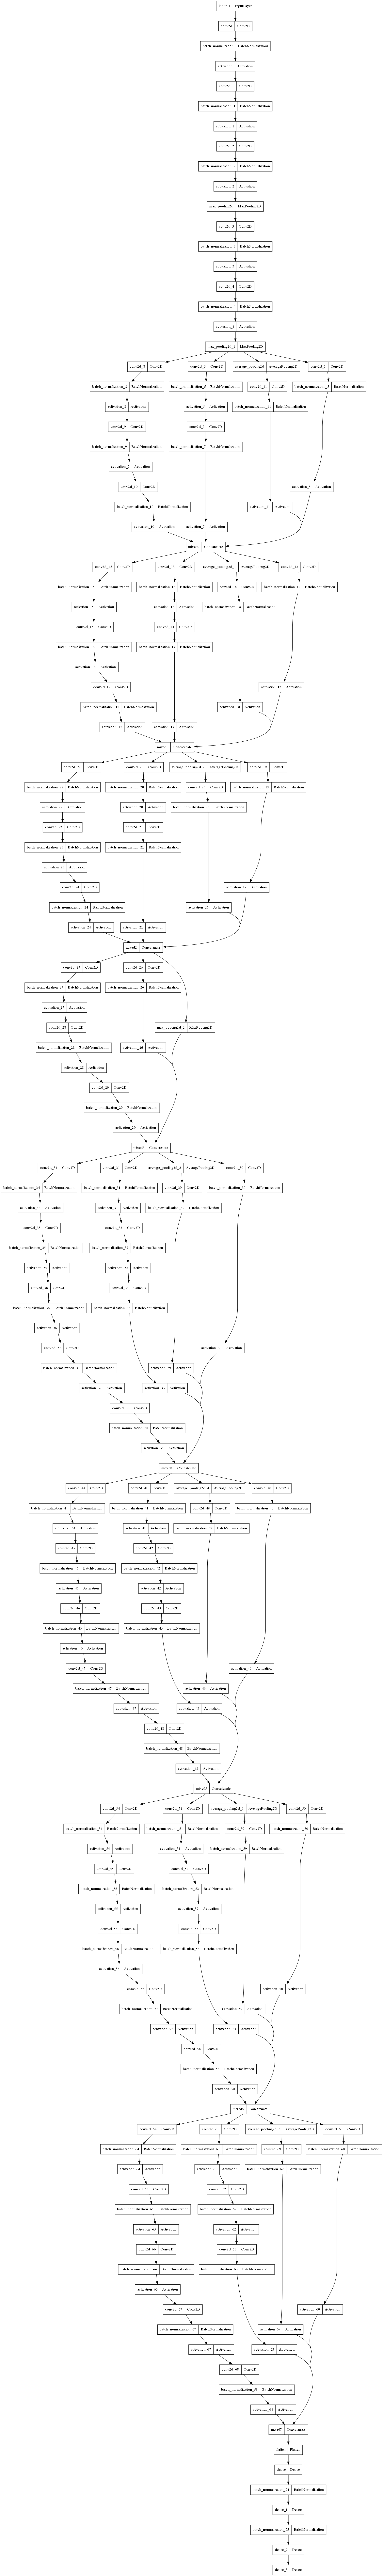

In [19]:
plot_model(model,to_file=os.path.join('architecture','model.png'),dpi=100)

In [21]:
import visualkeras

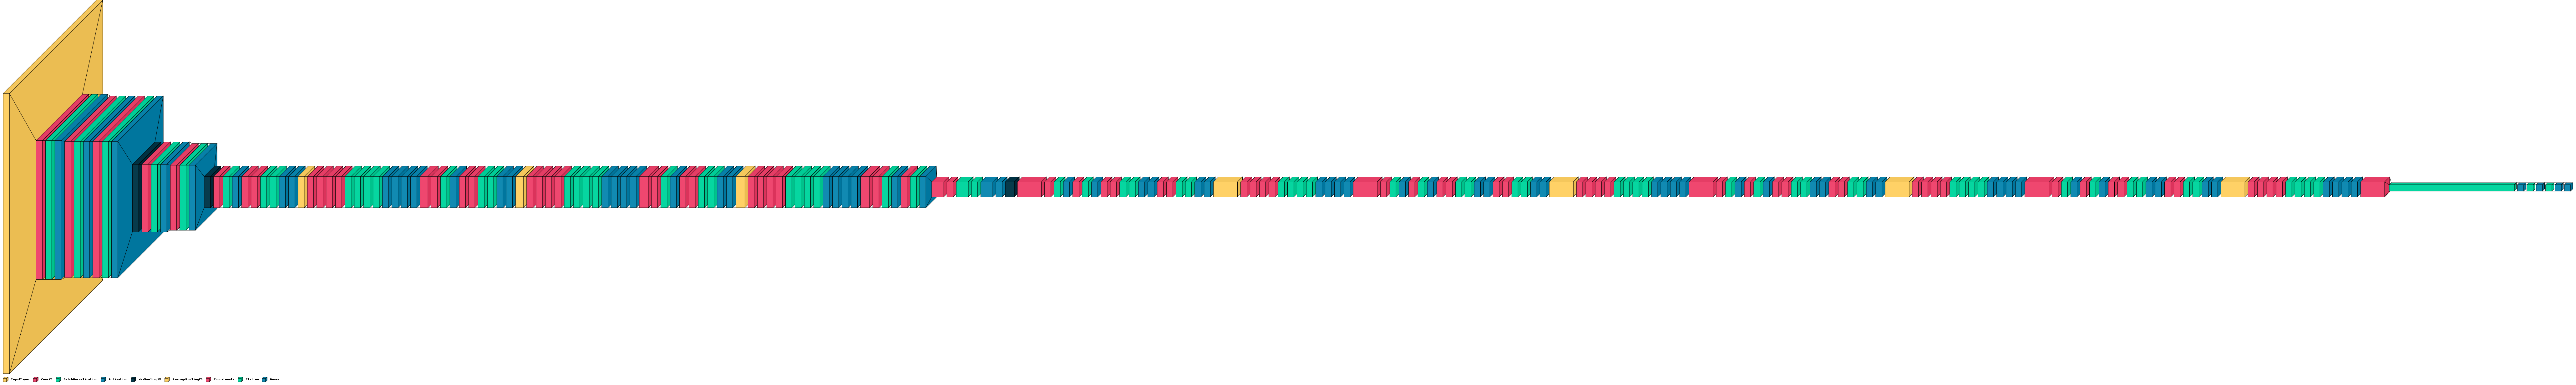

In [22]:
visualkeras.layered_view(model, legend=True,to_file='architecture\\layered_view.png')

# Train model

In [23]:
from tensorflow.keras.callbacks import TensorBoard,ModelCheckpoint,EarlyStopping

In [24]:
history=model.fit(
    train_data,
    epochs=3,
    validation_data=test_data,
    callbacks=[
        TensorBoard(log_dir='logs'),
        ModelCheckpoint('temp/checkpoint',save_weights_only=True,monitor='val_accuracy',save_best_only=True),
        EarlyStopping(monitor='val_loss',min_delta=0,patience=2,verbose=0,mode='auto',restore_best_weights=False)
    ]
  )

Epoch 1/3


InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "C:\Users\ivsvi\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\ivsvi\AppData\Roaming\Python\Python311\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\Users\ivsvi\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelapp.py", line 711, in start
      self.io_loop.start()
    File "C:\Users\ivsvi\AppData\Roaming\Python\Python311\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Program Files\Python311\Lib\asyncio\base_events.py", line 607, in run_forever
      self._run_once()
    File "c:\Program Files\Python311\Lib\asyncio\base_events.py", line 1919, in _run_once
      handle._run()
    File "c:\Program Files\Python311\Lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\ivsvi\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\ivsvi\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\ivsvi\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\ivsvi\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\ivsvi\AppData\Roaming\Python\Python311\site-packages\ipykernel\ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "C:\Users\ivsvi\AppData\Roaming\Python\Python311\site-packages\ipykernel\zmqshell.py", line 530, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\ivsvi\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "C:\Users\ivsvi\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "C:\Users\ivsvi\AppData\Roaming\Python\Python311\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\ivsvi\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\ivsvi\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\ivsvi\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\ivsvi\AppData\Local\Temp\ipykernel_44276\1182955418.py", line 1, in <module>
      history=model.fit(
    File "C:\Users\ivsvi\AppData\Roaming\Python\Python311\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ivsvi\AppData\Roaming\Python\Python311\site-packages\keras\engine\training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\ivsvi\AppData\Roaming\Python\Python311\site-packages\keras\engine\training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "C:\Users\ivsvi\AppData\Roaming\Python\Python311\site-packages\keras\engine\training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\ivsvi\AppData\Roaming\Python\Python311\site-packages\keras\engine\training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "C:\Users\ivsvi\AppData\Roaming\Python\Python311\site-packages\keras\engine\training.py", line 1051, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\ivsvi\AppData\Roaming\Python\Python311\site-packages\keras\engine\training.py", line 1109, in compute_loss
      return self.compiled_loss(
    File "C:\Users\ivsvi\AppData\Roaming\Python\Python311\site-packages\keras\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\ivsvi\AppData\Roaming\Python\Python311\site-packages\keras\losses.py", line 142, in __call__
      losses = call_fn(y_true, y_pred)
    File "C:\Users\ivsvi\AppData\Roaming\Python\Python311\site-packages\keras\losses.py", line 268, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\ivsvi\AppData\Roaming\Python\Python311\site-packages\keras\losses.py", line 2078, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "C:\Users\ivsvi\AppData\Roaming\Python\Python311\site-packages\keras\backend.py", line 5660, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
logits and labels must have the same first dimension, got logits shape [32,3] and labels shape [96]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_12361]

In [31]:
import pandas as pd

In [ ]:
df=pd.DataFrame(history.history)
df.to_csv('metrics.csv')

# Evaluate model

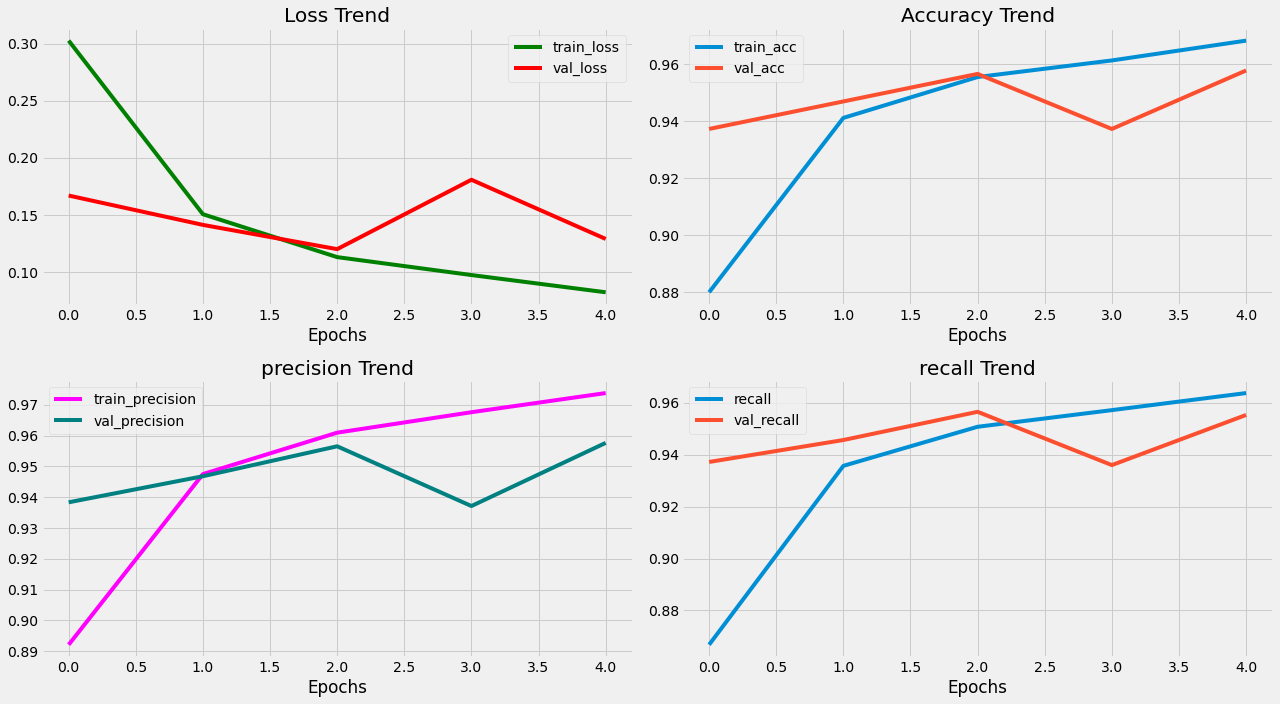

In [32]:
df=pd.read_csv('metrics.csv')
plt.style.use('fivethirtyeight')

fig,ax=plt.subplots(nrows=2,ncols=2,figsize=(18,10))
ax[0][0].plot(df['loss'],label='train_loss',color='green')
ax[0][0].plot(df['val_loss'],label='val_loss',color='red')
ax[0][0].set_title('Loss Trend')
ax[0][0].set_xlabel('Epochs')
ax[0][0].legend()

ax[0][1].plot(df['accuracy'],label='train_acc')
ax[0][1].plot(df['val_accuracy'],label='val_acc')
ax[0][1].set_title('Accuracy Trend')
ax[0][1].set_xlabel('Epochs')
ax[0][1].legend()

ax[1][0].plot(df['precision'],label='train_precision',color='magenta')
ax[1][0].plot(df['val_precision'],label='val_precision',color='teal')
ax[1][0].set_title('precision Trend')
ax[1][0].set_xlabel('Epochs')
ax[1][0].legend()

ax[1][1].plot(df['recall'],label='recall')
ax[1][1].plot(df['val_recall'],label='val_recall')
ax[1][1].set_title('recall Trend')
ax[1][1].set_xlabel('Epochs')
ax[1][1].legend()

fig.tight_layout()

# Save the model

In [43]:
model.save('metadata')
tf.keras.models.save_model(model,'models//tumor_classifier.h5')

# Load model

In [15]:
model.load_weights('models//tumor_classifier.h5')

In [49]:
model.predict(test_data.next()[0])

1/1 [==============================] - 2s 2s/step


array([[0.31470686, 0.3666242 , 0.31866902],
       [0.25717908, 0.32460693, 0.418214  ],
       [0.29420877, 0.34400633, 0.36178496],
       [0.21502039, 0.40239722, 0.3825824 ],
       [0.2852356 , 0.3642719 , 0.35049248],
       [0.31277022, 0.31597057, 0.37125918],
       [0.29150078, 0.33293968, 0.37555957],
       [0.27588233, 0.37603506, 0.3480826 ],
       [0.304055  , 0.32745025, 0.36849478],
       [0.28704697, 0.34679094, 0.3661621 ],
       [0.30292642, 0.3297771 , 0.36729652],
       [0.30205148, 0.3430614 , 0.35488713],
       [0.23712254, 0.38745883, 0.37541863],
       [0.30880857, 0.32143167, 0.36975977],
       [0.27594623, 0.3514501 , 0.37260368],
       [0.30980477, 0.3657955 , 0.32439974],
       [0.29358262, 0.33833775, 0.3680796 ],
       [0.28153512, 0.3556955 , 0.36276934],
       [0.2644655 , 0.38694113, 0.3485934 ],
       [0.33658063, 0.31600943, 0.34740993],
       [0.25322658, 0.35672513, 0.3900483 ],
       [0.26384762, 0.40659758, 0.3295548 ],
       [0.